In [1]:
#criei o repositório para guardar as anotações do estudos de modelos (principalmente de regressão

#Regressão Polinomial
#criação de dados quadráticos não lineares com ruído

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

m = 100 # instâncias de treinamento
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

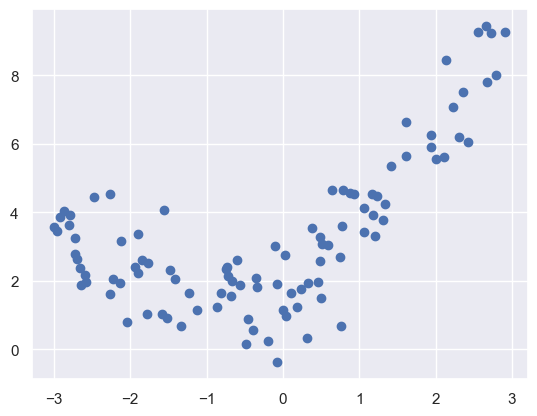

In [2]:
plt.scatter(X, y)
plt.show()

In [3]:
# Como boas práticas, é sempre necessário separar os conjuntos entre treino e teste.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [4]:
#para ajustar aos dados, usamos a classe PolynomialFeatures do SKLearn para transformar dados de treino, adicionando o quadrado de cada característica no conjunto de treinamento como uma nova característica

from sklearn.preprocessing import PolynomialFeatures
# include_bias=False: Evita adicionar uma coluna extra de 1s (que representa o viés/x^0).
# isso é feito porque a maioria dos modelos do SKLearn (como LinearRegression) já
# calcula o intercepto automaticamente, evitando assim duplicidade no termo de viés.
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X[0]

array([-2.22667176])

In [5]:
X_train_poly[0]

array([1.18276948, 1.39894365])

In [6]:
# X_train_poly tem a característica original de X mais o quadrado dessa característica, dando para ajustar os dados no LinearRegression

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

lin_reg.intercept_, lin_reg.coef_

(array([1.95563672]), array([[1.01067264, 0.55397695]]))

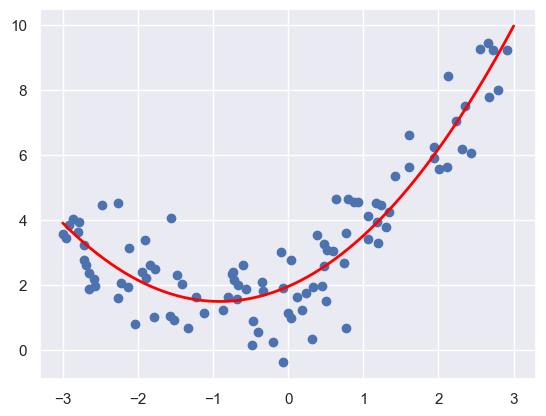

In [7]:
# em uma regressão polinomial, o modelo consegue encontrar relações entre várias características, coisa que a regressão linear não consegue. Isso por conta do PolynomialFeatures(degree=d)

#PolynomialFeatures(degree=3) não adiciona somente as características a^2, a^3, b^2, b^3, mas também as combinações de ab, a^2b, ab^2


X_new = np.linspace(-3, 3, 200).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.scatter(X, y)
plt.plot(X_new, y_new, color='red', linewidth=2)
plt.show()

In [8]:
#antes de plotar as curvas de aprendizado, o livro fala sobre utilizar a validação cruzada para verificar se o modelo está se sobre ou sub-ajustando
#como já dividi os conjuntos de treino e teste, e transformei o conjunto de testes, irei aplicar a cross-validation no conjunto de treino transformado.

from sklearn.model_selection import cross_val_score
scores_test = cross_val_score(lin_reg, X_train_poly, y_train, cv=10, scoring='neg_mean_squared_error')

In [9]:
#convertemos para RMSE para ficar na mesma escala de y
lin_rmse_scores = np.sqrt(-scores_test)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

from sklearn.metrics import mean_squared_error
y_train_pred = lin_reg.predict(X_train_poly)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE TRAIN:", rmse_train)

Scores: [0.97277158 1.19819088 1.18390682 1.15916922 1.12145808 0.80836155
 0.80671693 0.67859118 1.1845245  1.09271678]
Mean: 1.020640752836378
Standard deviation: 0.18157703475734857
RMSE TRAIN: 0.9900887071814045


In [10]:
from sklearn.metrics import mean_squared_error
y_train_pred = lin_reg.predict(X_train_poly)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_train

np.float64(0.9900887071814045)

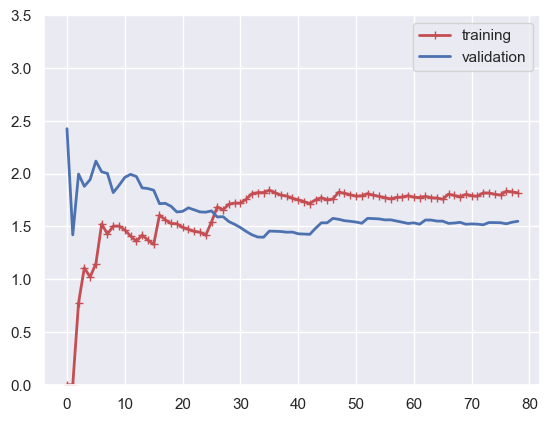

In [11]:
#curvas de aprendizado
#além da cross validation, podemos utilizar as curvas de aprendizado para saber se o modelo está tendo over ou underfitting. Elas são gráfios de desempenho do modelo no conjunto de treinamento e validação.

#Estamos criando as curvas de aprendizado de uma regressão linear simples

def plot_learning_curves(model,X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val_pred, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label='training')
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label='validation')
    plt.ylim(0, 3.5)
    plt.legend()
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

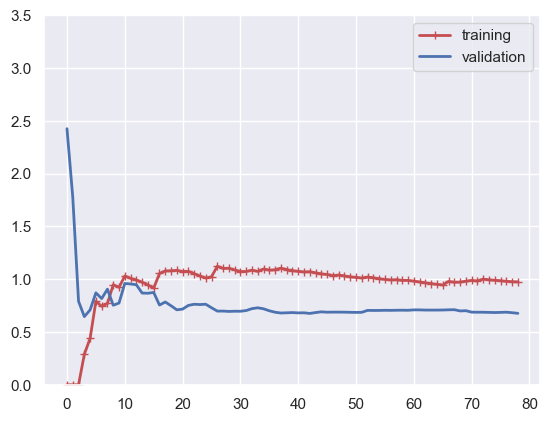

In [12]:
# aqui definimos os modelos para a função de plotar as curvas de aprendizado, onde podemos ver que a regressão polinomial de 2º grau se adequa de melhor forma aos dados. O erro se tornou mais baixo que a regressão linear e as curvas de erro ficaram próximas, não significando underfitting.

from sklearn.pipeline import Pipeline

poly_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(poly_regression, X, y)

In [13]:
# Modelos lineares regularizados → uma boa forma de reduzir overfitting, restringindo o modelo nos seus graus de liberdade

#Regressão de ridge → versão regularizada da regressão linear
#o termo de regularização é adicionado à função de custo, junto à isso é fundamental escalonar os dados antes de realizar a regressão.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_poly)

# podemos fazer a regressão pela fórmula fechada (caderno) ou pelo gradiente descendente
from sklearn.linear_model import Ridge
ridge_regression = Ridge(alpha=1, solver='cholesky') #estamos utilizando a técnica de fatoração de matriz de André-Louis Cholesky
ridge_regression.fit(X_scaled, y_train)

x_input_poly = poly_features.transform([[1.5]])
x_input_scaled = scaler.transform(x_input_poly)

pred_scaled = ridge_regression.predict(x_input_scaled)

print(pred_scaled)


[4.69763428]


In [14]:
#e com o SGD estocástico
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty='l2') # define o tipo de termo de regularização. indica que quero que o SGD acrescente um termo de regularização à função de custo
sgd_reg.fit(X_scaled, y_train.ravel()) # exige que o vetor alvo y seja 1D, isso converte (n,1) em (n,)
pred_scaled_sgd = sgd_reg.predict(x_input_scaled)

print(pred_scaled_sgd)

[4.66235558]


In [15]:
print("Ridge", pred_scaled)
print("SGD", pred_scaled_sgd)

Ridge [4.69763428]
SGD [4.66235558]


In [17]:
#Regressão de Lasso

from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=.1)
lasso_reg.fit(X_scaled, y_train)
pred_scaled_lasso = lasso_reg.predict(x_input_scaled)

print("Ridge", pred_scaled)
print("SGD", pred_scaled_sgd)
print("Lasso", pred_scaled_lasso)

Ridge [4.69763428]
SGD [4.66235558]
Lasso [4.62376998]


In [29]:
lasso_reg = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1, max_iter=10000, tol=0.001)),
])

C:\Users\felipetp\PycharmProjects\handsOnML-housing\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


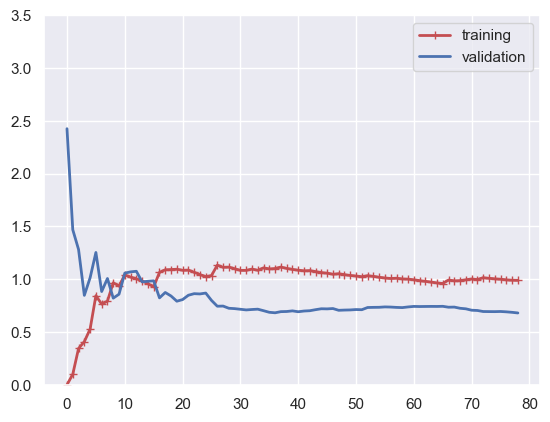

In [30]:
def plot_learning_curves_scaled(model,X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val_pred, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label='training')
    plt.plot(np.sqrt(val_errors), "b-", linewidth=2, label='validation')
    plt.ylim(0, 3.5)
    plt.legend()

plot_learning_curves(lasso_reg, X, y)

In [31]:
from sklearn.metrics import r2_score, mean_absolute_error
scores_test = cross_val_score(lasso_reg, X,y, cv=10, scoring='neg_mean_squared_error')
lasso_rmse_scores = np.sqrt(-scores_test)

display_scores(lasso_rmse_scores)

lasso_reg.fit(X_train, y_train)

y_train_pred = lasso_reg.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("RMSE TRAIN:", rmse_train)
print('R² train score', r2_score(y_train, y_train_pred))
print('MAE train score', mean_absolute_error(y_train, y_train_pred))

Scores: [1.00546861 1.31400091 0.86150815 0.89280625 0.59982147 0.99056916
 1.18460483 0.59609064 1.2405298  0.73480642]
Mean: 0.942020624004005
Standard deviation: 0.2411050852572915
RMSE TRAIN: 1.0042836609943007
R² train score 0.7964291183567451
MAE train score 0.8105841867822743


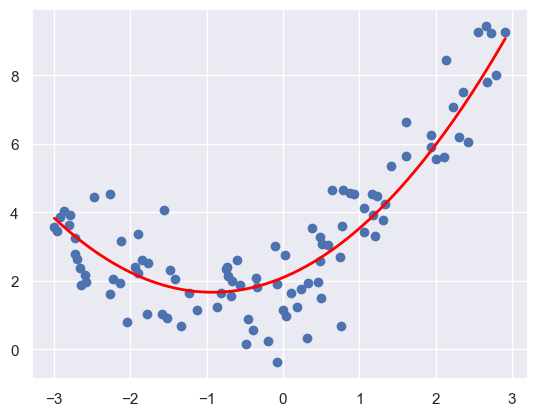

In [41]:
X_new = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
y_new = lasso_reg.predict(X_new)

plt.scatter(X, y)
plt.plot(X_new, y_new, color='red', linewidth=2)
plt.show()

In [1]:
print('hello world')

hello world
